# Task:
1. Simulate player gameplay 
2. Estimate their average spend
3. Determine fixed rewards for each completed level. The reward structure should be designed in such a way that the expected value of player rewards equals 1.3 times their
average spend (including any additional deposits).

### 1. Simulation of Gameplay
The player progresses through the levels by playing slot games. Upon reaching specific multipliers (e.g. x25, x50, etc.) in a limited time, the player advances to the next level. 

##### i. Player progression:
- Player enters a challenge at level 1 with a non zero bankroll (approx. 50 EUR)
- Players must hit or exceed the target multiplier in the given time.
- If they reached the next level the unused time is added to the next level.
- Players can add additional funds up to 4 times.

##### ii. End of the game:
- Players do not reach or surpass the target multiplaier in the given time
- Players reach the max multiplaier
- Players run out of money

### 2. Exploration of Variables

How results vary based on: (given a slot machine)
- initial bankroll size: 10, 20, 50 €
- additional deposit (max 4)
- bet size: 1, 2, 5, 10, 20, 50 €

### 3. Reward Design

- Define a fixed monetary reward for each level.
- Ensure the prize structure logically scales with level difficulty and encourages
progression.
- The target is for the expected value of the rewards to equal 1.3× the player’s average
spend, including all deposits. Example: A player deposits a total €100 of their funds
into playing; the rewards should total €130.


### 4. Key metrics:

- player distribution across the levels
- avg. spend per level for all levels
- avg. time spend per level (potential indicator for player engagement)
- avg. reward per level



### 5. Assumptions:
- Spin time: 
    - 2 s (autospin)
    - 5 s (player input) 
- Bet size: 1, 2, 5, 10, 20, 50 € (just mimicking the currency options)

### Used libraries and given data
Numpy, matplotlib, pandas, ipytest

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import ipytest
import pandas as pd
import csv
import os
ipytest.autoconfig()         # picks up `pytest.ini` in cwd, if any



In [5]:
slot_machine_levels = {
    1: {
        "target_multiplier": 25,
        "time_limit": "30 min",
        "time_seconds": 30 * 60
    },
    2: {
        "target_multiplier": 50,
        "time_limit": "1 hour",
        "time_seconds": 1 * 60 * 60
    },
    3: {
        "target_multiplier": 100,
        "time_limit": "2 hours",
        "time_seconds": 2 * 60 * 60
    },
    4: {
        "target_multiplier": 200,
        "time_limit": "3 hours",
        "time_seconds": 3 * 60 * 60
    },
    5: {
        "target_multiplier": 500,
        "time_limit": "4 hours",
        "time_seconds": 4 * 60 * 60
    },
    6: {
        "target_multiplier": 800,
        "time_limit": "6 hours",
        "time_seconds": 6 * 60 * 60
    },
    7: {
        "target_multiplier": 1500,
        "time_limit": "8 hours",
        "time_seconds": 8 * 60 * 60
    },
    8: {
        "target_multiplier": 2500,
        "time_limit": "12 hours",
        "time_seconds": 12 * 60 * 60
    },
    9: {
        "target_multiplier": 5000,
        "time_limit": "24 hours",
        "time_seconds": 24 * 60 * 60
    },
    10: {
        "target_multiplier": 10000,
        "time_limit":"48 hours",
        "time_seconds":48 * 60 * 60 
    }
}

print(slot_machine_levels)

slot1 = np.load('data/multipliers_slot_1.npy')
slot2 = np.load('data/multipliers_slot_2.npy')
print(type(slot1), slot1.shape)

{1: {'target_multiplier': 25, 'time_limit': '30 min', 'time_seconds': 1800}, 2: {'target_multiplier': 50, 'time_limit': '1 hour', 'time_seconds': 3600}, 3: {'target_multiplier': 100, 'time_limit': '2 hours', 'time_seconds': 7200}, 4: {'target_multiplier': 200, 'time_limit': '3 hours', 'time_seconds': 10800}, 5: {'target_multiplier': 500, 'time_limit': '4 hours', 'time_seconds': 14400}, 6: {'target_multiplier': 800, 'time_limit': '6 hours', 'time_seconds': 21600}, 7: {'target_multiplier': 1500, 'time_limit': '8 hours', 'time_seconds': 28800}, 8: {'target_multiplier': 2500, 'time_limit': '12 hours', 'time_seconds': 43200}, 9: {'target_multiplier': 5000, 'time_limit': '24 hours', 'time_seconds': 86400}, 10: {'target_multiplier': 10000, 'time_limit': '48 hours', 'time_seconds': 172800}}
<class 'numpy.ndarray'> (10000000,)


### Slot statistics
Just a quick look at the slots statitics.

In [6]:
slot1_series = pd.Series(slot1, name="Slot 1")
slot2_series = pd.Series(slot2, name="Slot 2")

df_slot_stats = pd.concat([slot1_series, slot2_series], axis=1)

print(df_slot_stats.describe())


             Slot 1        Slot 2
count  1.000000e+07  2.000000e+07
mean   9.509598e-01  9.670817e-01
std    6.934455e+00  1.232296e+01
min    0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00
75%    1.666000e-01  0.000000e+00
max    7.000000e+02  1.470825e+04


### Spinning
Simulating the slot spin rezult with uniformly choosing a slot outcome.

In [7]:

def spin(slot):
    random_value = np.random.choice(slot)
    return random_value


In [8]:

def check_multi(level, current_multiplier, remaining_spins, spin_time):
    """
    Returns: next_level, remaining_time
      next_level (int) if current_multiplier >= target and elapsed_seconds <= time_limit
      1            if the player failed (reset to level 1)
    """
    info = slot_machine_levels.get(level)
    time_limit = info["time_seconds"]
    target = info["target_multiplier"]
    all_spins_per_lvl = slot_machine_levels[level]["time_seconds"]/spin_time

    if not info:
        # invalid level: reset
        return 1, 0.0

    if (current_multiplier >= target
        and remaining_spins >= 0):
        next_level = level +1
        # remaining_time = slot_machine_levels[level]["time_seconds"]/spin_time - used_spins
        return next_level, remaining_spins+slot_machine_levels[next_level]["time_seconds"]/spin_time
    # elif(remaining_spins<=0):
    #     return 1, 0.0
    else:
        return level, remaining_spins

def test_check_multi():
    # player next lvl reached multi = 30 > target = 25 in 10 min, 20 min remains
    assert(check_multi(1, 30, 10*60, 1)) == (2, 4200)
    # player loses per multiplier
    assert(check_multi(1, 10, 600, 1))== (1, 600)
    assert(check_multi(1, 30, 5*60, 2)) == (2, 2100)
    # assert False, "This test is designed to always fail"



### User Cash Flow Oversight
assumption u add money only when u cant bet anymore

In [9]:
def cash_flow(total_spend, bet_size: float, balance: float, deposit: float, added_fund: int):
    keep_plaing = 1 

    if bet_size<=balance:
        balance -= bet_size

    elif bet_size>balance and added_fund<4:
        #total_spend +=balance
        balance += deposit
        added_fund += 1
        balance -= bet_size
        total_spend += deposit
    
    elif balance < bet_size and added_fund==4:
        keep_plaing = 0
    
    return total_spend, balance, added_fund, keep_plaing


def test_cash_flow():
    # positive balance
    assert(cash_flow(10.0, 0, 10.0, 0, 0) == (10.0, 10.0, 0, 1))
    # no balance
    assert(cash_flow(0, 20.0, 0, 0, 4) == (0.0, 0.0, 4, 0))
    # add deposit
    assert(cash_flow(10.00, 11.0, 10.0, 20.0, 1))==(30.0, 19.0, 2, 1)
    # last deposit
    assert(cash_flow(10, 15, 10, 5, 3))==(15, 0, 4, 1)
    # no bet
    assert(cash_flow(10, 15, 10, 5, 4))==(10, 10, 4, 0)
    # a test that fails
    #ssert False, "This test is designed to always fail"

assumption
- players have a max of 48h to paticipate to the promo challange
- players want to maximize their time per spins --> using all the 48h for betting

In [48]:
auto_spin = 2 # s
lvl = 1
start_balance = 10 #EUR
star_bet = 10 #EUR
added_fund = 0
#total_spend = 0

def player_gameplay(spin_time):
    total_spend = start_balance
    balance = start_balance
    total_multiplier = 0
    keep_playing = 1
    remaining_spins = 900
    lvl = 1
    added_fund = 0
    while keep_playing and lvl < 10:

        remaining_spins -=1
        spin_rezult = spin(slot1)
        total_multiplier+= spin_rezult
        cash = spin_rezult*star_bet

        next_lvl, remaining_spins = check_multi(lvl, total_multiplier, remaining_spins, spin_time)
        lvl = next_lvl
        
        total_spend, new_balance, add_times, keep_playing = cash_flow(total_spend, star_bet, balance, start_balance, added_fund)
        added_fund = add_times
        balance = new_balance+cash

            
            #balance = new_balance
        if remaining_spins==0:
            keep_playing=0
        # print("lvl", next_lvl,"remainig spins", remaining_spins)
        # print("cash:", star_bet, "balance",balance, "add: ",add_times)
        # print("total", total_spend)
        # print("")
    return lvl, remaining_spins, balance, total_spend, add_times

player_gameplay(auto_spin)

(1, 892, np.float32(2.6650004), 50, 4)

In [49]:
def run_and_save(spin_time, runs=1000, output_file='gameplay_results.csv'):
    # Check whether the file already exists (so we know to write header or not)
    file_exists = os.path.isfile(output_file)
    
    # Open in append mode
    with open(output_file, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # If the file didn’t exist before, write the header
        if not file_exists:
            writer.writerow(['level', 'remaining_spins', 'balance', 'total_spend', 'add_times'])
        
        # Run the simulation and append each result
        for _ in range(runs):
            lvl, remaining_spins, balance, total_spend, add_times = player_gameplay(spin_time)
            writer.writerow([lvl, remaining_spins, balance, total_spend, add_times])

if __name__ == '__main__':
    run_and_save(2, 5000, 'gameplay_init10_bet10.csv')
    print("Done: results saved to .csv")

Done: results saved to .csv


In [ ]:
# running tests
ipytest.run()

### Results and analysis

In [15]:
data_auto_spin = pd.read_csv('gameplay_results.csv')
data_avg_human = pd.read_csv('gameplay_results_avg_human.csv')

data_auto_spin.describe()

,level,remaining_spins,balance,total_spend,add_times
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,7.769000,84621.435000,112.620054,228.340000,3.56680
std,1.708632,63356.873777,259.390170,52.070977,1.04142
min,3.000000,5963.000000,0.000229,50.000000,0.00000
25%,6.000000,28949.000000,0.487297,250.000000,4.00000
50%,8.000000,63272.500000,0.840281,250.000000,4.00000
75%,9.000000,105914.250000,6.865700,250.000000,4.00000
max,10.000000,191844.000000,1659.342300,250.000000,4.00000


In [ ]:
data_avg_human.describe()

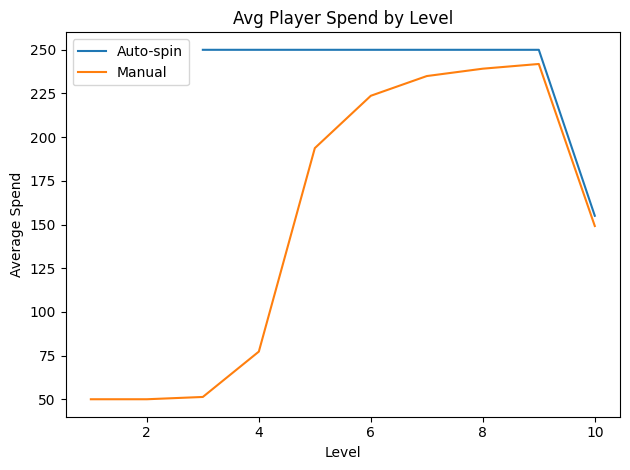

In [52]:
avg_spend = data_auto_spin.groupby('level')['total_spend'].mean()
avg_spend_human = data_avg_human.groupby('level')['total_spend'].mean()

fig, ax = plt.subplots()
avg_spend.plot(kind='line', ax=ax, label='Auto-spin')
avg_spend_human.plot(kind='line', ax=ax, label='Manual')

ax.set_xlabel('Level')
ax.set_ylabel('Average Spend')
ax.set_title('Avg Player Spend by Level')
ax.legend()

plt.tight_layout()
plt.show()

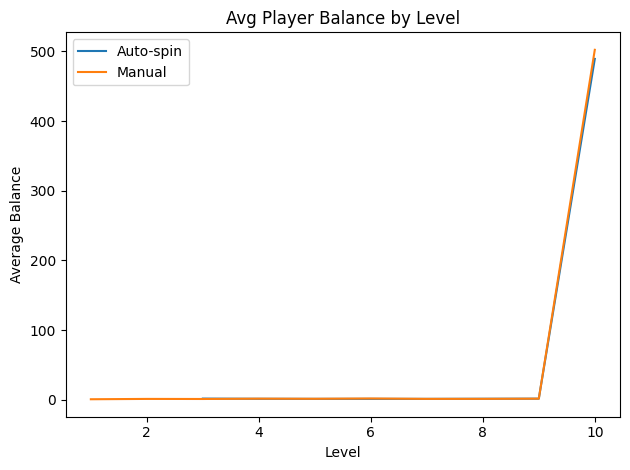

In [ ]:
avg_balance = data_auto_spin.groupby('level')['balance'].mean()
avg_balance_human = data_avg_human.groupby('level')['balance'].mean()

fig, ax = plt.subplots()
avg_balance.plot(kind='line', ax=ax, label='Auto-spin')
avg_balance_human.plot(kind='line', ax=ax, label='Manual')

ax.set_xlabel('Level')
ax.set_ylabel('Average Balance')
ax.set_title('Avg Player Balance by Level')
ax.legend()

plt.tight_layout()
plt.show()


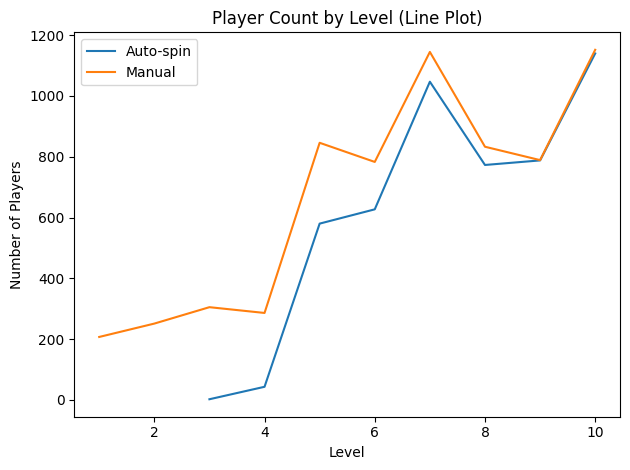

In [50]:
counts_player_auto = data_auto_spin['level'].value_counts().sort_index()
counts_player_human = data_avg_human['level'].value_counts().sort_index()

fig, ax = plt.subplots()
counts_player_auto.plot(kind='line', ax=ax, label='Auto-spin')
counts_player_human.plot(kind='line', ax=ax, label='Manual')

ax.set_xlabel('Level')
ax.set_ylabel('Number of Players')
ax.set_title('Player Count by Level (Line Plot)')
ax.legend()

plt.tight_layout()
plt.show()

The distribution of player, balance and avarage spend per level do not vary significantly regardless if there is a person clicking spin or just using autospin. From now on the results will include autospin simulations only.

### Constant initial bankroll and different bet sizes

In [69]:
init_10_bet1 = pd.read_csv('gameplay_init10_bet1.csv')
init_10_bet2 = pd.read_csv('gameplay_init10_bet2.csv')
init_10_bet5 = pd.read_csv('gameplay_init10_bet5.csv')
init_10_bet10 = pd.read_csv('gameplay_init10_bet10.csv')

init_20_bet1  = pd.read_csv('gameplay_init20_bet1.csv')
init_20_bet2  = pd.read_csv('gameplay_init20_bet2.csv')
init_20_bet5  = pd.read_csv('gameplay_init20_bet5.csv')
init_20_bet10 = pd.read_csv('gameplay_init20_bet10.csv')

init_50_bet1  = data_auto_spin
init_50_bet2  = pd.read_csv('gameplay_init50_bet2.csv')
init_50_bet5  = pd.read_csv('gameplay_init50_bet5.csv')
init_50_bet10 = pd.read_csv('gameplay_init50_bet10.csv')


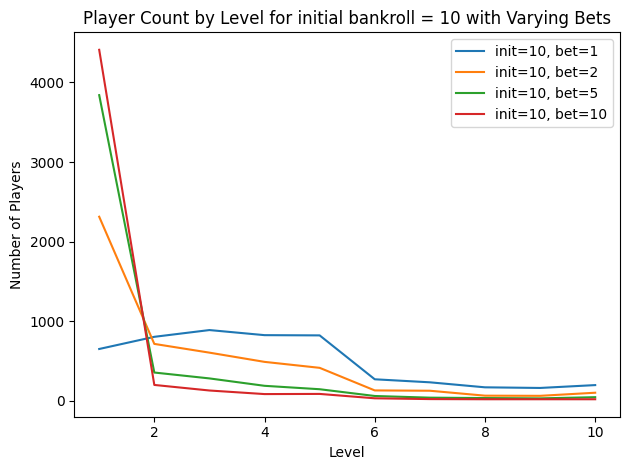

In [62]:
init_10_bet1_lvl = init_10_bet1['level'].value_counts().sort_index()
init_10_bet2_lvl = init_10_bet2['level'].value_counts().sort_index()
init_10_bet5_lvl = init_10_bet5['level'].value_counts().sort_index()
init_10_bet10_lvl = init_10_bet10['level'].value_counts().sort_index()

fig, ax = plt.subplots()

init_10_bet1_lvl.plot(kind='line', ax=ax, label='init=10, bet=1')
init_10_bet2_lvl.plot(kind='line', ax=ax, label='init=10, bet=2')
init_10_bet5_lvl.plot(kind='line', ax=ax, label='init=10, bet=5')
init_10_bet10_lvl.plot(kind='line', ax=ax, label='init=10, bet=10')

ax.set_xlabel('Level')
ax.set_ylabel('Number of Players')
ax.set_title('Player Count by Level for initial bankroll = 10 with Varying Bets')
ax.legend()

plt.tight_layout()
plt.show()

In [64]:
init_10_bet1_avg_spend  = init_10_bet1 .groupby('level')['total_spend'].mean().sort_index()
init_10_bet2_avg_spend  = init_10_bet2 .groupby('level')['total_spend'].mean().sort_index()
init_10_bet5_avg_spend  = init_10_bet5 .groupby('level')['total_spend'].mean().sort_index()
init_10_bet10_avg_spend = init_10_bet10.groupby('level')['total_spend'].mean().sort_index()


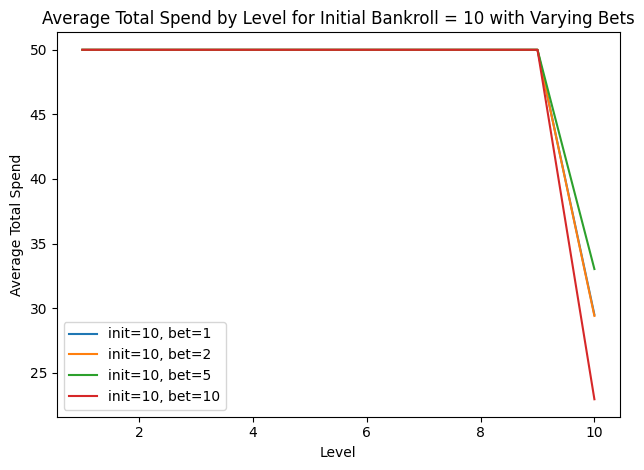

In [65]:
fig, ax = plt.subplots()

init_10_bet1_avg_spend.plot(kind='line', ax=ax, label='init=10, bet=1')
init_10_bet2_avg_spend.plot(kind='line', ax=ax, label='init=10, bet=2')
init_10_bet5_avg_spend.plot(kind='line', ax=ax, label='init=10, bet=5')
init_10_bet10_avg_spend.plot(kind='line', ax=ax, label='init=10, bet=10')

ax.set_xlabel('Level')
ax.set_ylabel('Average Total Spend')
ax.set_title('Average Total Spend by Level for Initial Bankroll = 10 with Varying Bets')
ax.legend()

plt.tight_layout()
plt.show()

In [66]:
init_10_bet1_avg_balance  = init_10_bet1 .groupby('level')['balance'].mean().sort_index()
init_10_bet2_avg_balance  = init_10_bet2 .groupby('level')['balance'].mean().sort_index()
init_10_bet5_avg_balance  = init_10_bet5 .groupby('level')['balance'].mean().sort_index()
init_10_bet10_avg_balance = init_10_bet10.groupby('level')['balance'].mean().sort_index()


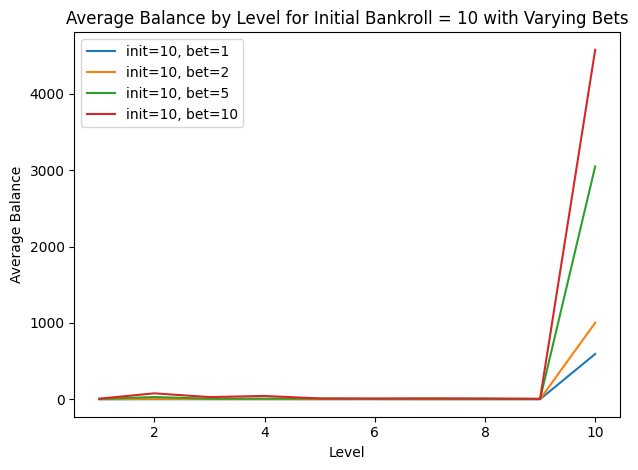

In [ ]:
fig, ax = plt.subplots()

init_10_bet1_avg_balance.plot(kind='line', ax=ax, label='init=10, bet=1')
init_10_bet2_avg_balance.plot(kind='line', ax=ax, label='init=10, bet=2')
init_10_bet5_avg_balance.plot(kind='line', ax=ax, label='init=10, bet=5')
init_10_bet10_avg_balance.plot(kind='line', ax=ax, label='init=10, bet=10')

ax.set_xlabel('Level')
ax.set_ylabel('Average Balance')
ax.set_title('Average Balance by Level for Initial Bankroll = 10 with Varying Bets')
ax.legend()

plt.tight_layout()
plt.show()

### Same bet size varing initial bankroll

In [71]:
init_20_bet1_avg_balance = init_20_bet1.groupby('level')['balance'].mean().sort_index()
init_50_bet1_avg_balance = init_50_bet1.groupby('level')['balance'].mean().sort_index()


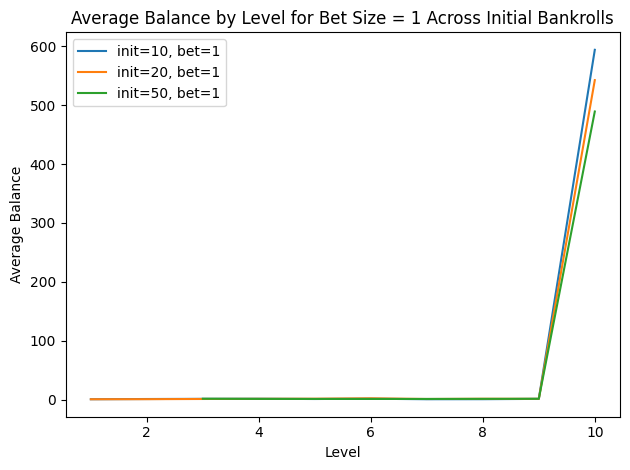

In [72]:
fig, ax = plt.subplots()

init_10_bet1_avg_balance.plot(kind='line', ax=ax, label='init=10, bet=1')
init_20_bet1_avg_balance.plot(kind='line', ax=ax, label='init=20, bet=1')
init_50_bet1_avg_balance.plot(kind='line', ax=ax, label='init=50, bet=1')

ax.set_xlabel('Level')
ax.set_ylabel('Average Balance')
ax.set_title('Average Balance by Level for Bet Size = 1 Across Initial Bankrolls')
ax.legend()

plt.tight_layout()
plt.show()

In [73]:
init_10_bet10_avg_balance = init_10_bet10 .groupby('level')['balance'].mean().sort_index()
init_20_bet10_avg_balance = init_20_bet10 .groupby('level')['balance'].mean().sort_index()
init_50_bet10_avg_balance = init_50_bet10 .groupby('level')['balance'].mean().sort_index()


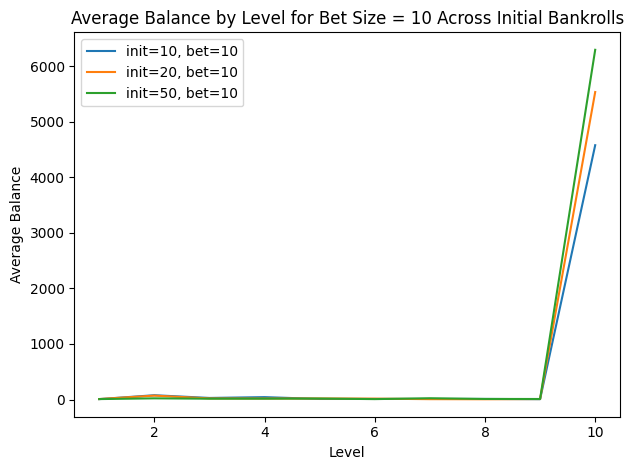

In [74]:
fig, ax = plt.subplots()

init_10_bet10_avg_balance.plot(kind='line', ax=ax, label='init=10, bet=10')
init_20_bet10_avg_balance.plot(kind='line', ax=ax, label='init=20, bet=10')
init_50_bet10_avg_balance.plot(kind='line', ax=ax, label='init=50, bet=10')

ax.set_xlabel('Level')
ax.set_ylabel('Average Balance')
ax.set_title('Average Balance by Level for Bet Size = 10 Across Initial Bankrolls')
ax.legend()

plt.tight_layout()
plt.show()

### Reward design

In [77]:
all_runs = pd.concat([
    init_10_bet1, init_10_bet2, init_10_bet5, init_10_bet10,
    init_20_bet1, init_20_bet2, init_20_bet5, init_20_bet10,
    init_50_bet1, init_50_bet2, init_50_bet5, init_50_bet10
], ignore_index=True)

avg_balance_all_levels = all_runs.groupby('level')['balance'].mean().sort_index()
avg_total_spend_all_levels = all_runs.groupby('level')['total_spend'].mean().sort_index()

print(avg_balance_all_levels)
print(avg_total_spend_all_levels)

level
1        6.352791
2       16.718251
3        6.728242
4        5.875456
5        5.295730
6        3.299760
7        3.375202
8        2.854515
9        3.073935
10    1147.011789
Name: balance, dtype: float64
level
1      94.744661
2     124.679715
3     128.170103
4     140.108862
5     154.517266
6     171.103271
7     186.424501
8     186.492122
9     189.712591
10    118.865711
Name: total_spend, dtype: float64
